# Xarray interface for neoclassical transport

## `SymbolicEquilibrium`

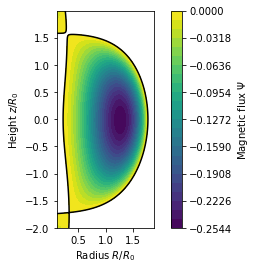

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 1.25, "A": -0.05, "elongation": 2, "triangularity": 0.3}
# TODO this is still not taken in

eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null",
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

In [2]:
from tqdm.auto import tqdm

In [3]:
import astropy.units as u
import numpy as np
import pandas as pd
import xarray

data_df = pd.read_csv("/home/dominik/IFPILM/Magisterka/HoulbergNSTX.csv", index_col=0)

<AxesSubplot:xlabel='x'>

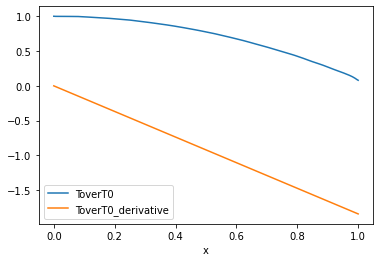

In [4]:
data_df[["x", "ToverT0", "ToverT0_derivative"]].plot(x="x")

<AxesSubplot:xlabel='x'>

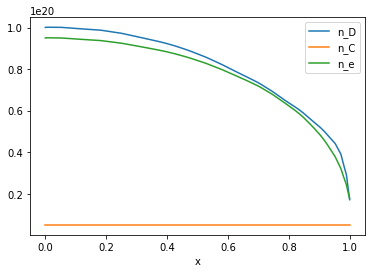

In [5]:
data_df[["x", "n_D", "n_C", "n_e"]].plot(x="x")

<AxesSubplot:xlabel='x'>

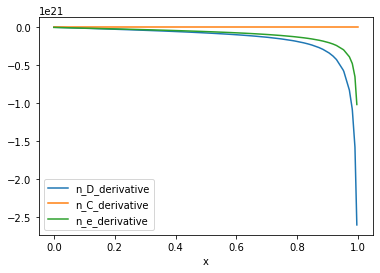

In [6]:
data_df[["x", "n_D_derivative", "n_C_derivative", "n_e_derivative"]].plot(x="x")

In [7]:
T_i = T_e = T_C6 = data_df["ToverT0"] * 0.5 * 1000
dT_i = dT_e = dT_C6 = data_df["ToverT0_derivative"] * 0.5 * 1000
n_e, dn_e = data_df["n_e"], data_df["n_e_derivative"]
n_i, dn_i = data_df["n_D"], data_df["n_D_derivative"]
n_C6, dn_C6 = data_df["n_C"], data_df["n_C_derivative"]

rho = data_df.x.values

## Multiple flux surfaces - radial grid

## `FlowCalculator`

In [8]:
import xarray
attrs = {
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    }

dataset_H1 = xarray.Dataset(
    {
        "T": ("rho", T_i),
        "gradT": ("rho", dT_i),
        "n": ("rho", n_i),
        "gradn": ("rho", dn_i),
        "charges": 1,
    },
    coords={"rho": rho, "particle": "H 1+"},
    attrs=attrs,
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("rho", T_C6),
        "gradT": ("rho", dT_C6),
        "n": ("rho", n_C6),
        "gradn": ("rho", dn_C6),
        "charges": 6,
    },
    coords={"rho": rho, "particle": "C 6+"},
    attrs=attrs,
)
dataset_e = xarray.Dataset(
    {
        "T": ("rho", T_e),
        "gradT": ("rho", dT_e),
        "n": ("rho", n_e),
        "gradn": ("rho", dn_e),
        "charges": -1,
    },
    coords={"rho": rho, "particle": "e-"},
    attrs=attrs,
)

dataset = xarray.concat([
    dataset_H1,
    dataset_C6,
    dataset_e,
], dim="particle")
# dataset["rho"] = ("rho", rho)
dataset["charge_density"] = "rho", (dataset.charges * dataset.n).sum(dim="particle")

dataset["psi"] = eq.rho_to_psi(rho)
dataset

In [10]:
# final_dataset = dataset

final_rho = np.linspace(0.61277, 0.61282, 500)
final_rho = np.linspace(0, 1, 50)
final_dataset = dataset.interp({"rho": final_rho})

  0%|          | 0/50 [00:00<?, ?it/s]

/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__a

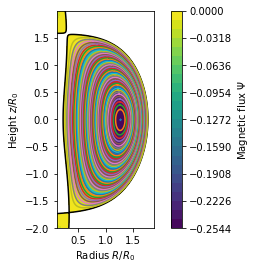

In [11]:
from plasmapy.transport.flows import FlowCalculator
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
fcs = []
surfaces = []
all_mu = []
datasets = []
for i, (_, surface) in enumerate(tqdm(
        eq.get_multiple_flux_surfaces(
            rho_values=final_dataset.rho, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep
        ),
        total=final_dataset.rho.size,
    )):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fc = FlowCalculator.from_xarray_surface(final_dataset.isel(rho=i), surface)
    try:
        dataset = fc.to_dataset()
    except ValueError:
        continue
    fcs.append(fc)
    all_species = fc.all_species
    all_mu.append(all_species.mu_hat(surface))
    datasets.append(dataset)
    surfaces.append(surface)
    surface.plot(ax)
ax.legend().remove()

In [12]:
results = xarray.concat(datasets, dim="rho")
results["mu_hat"] = ("rho", "particle", "alpha", "beta"), u.Quantity(all_mu).si.value
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m ** 2)
results = results.assign(
    bootstrap_current_normalized=results.bootstrap_current * scaling
)

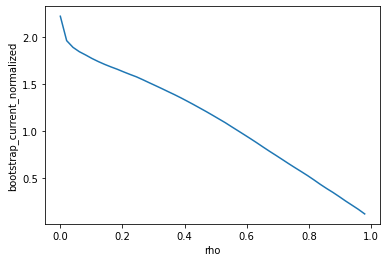

In [13]:
results.bootstrap_current_normalized.plot.line()

In [14]:
# imax = int(np.abs(results.bootstrap_current_normalized).argmax())
# extr = results.isel(psi=imax, rho=imax)

# fs = surfaces[imax][1]

# fc = fcs[imax]

# all_species = fc.all_species

# results["effective_momentum_relaxation_"]

In [15]:
# results.sel(particle="e-").mu_hat.mean(dim=["alpha", "beta"]).plot.line(x="rho")

In [16]:
eq.get_flux_surface

<bound method SymbolicEquilibrium.get_flux_surface of SymbolicEquilibrium(aspect_ratio=0.78, A=-0.05, elongation=2, triangularity=0.35, config='single-null', B0=0.3)>

In [17]:
# rho_to_surface[float(extr.rho)]

# surfaces[imax]

# surfaces[imax]

results.thermal_conductivity

<xarray.DataArray 'thermal_conductivity' (rho: 49, particle: 3)>
array([[            inf,             inf,             inf],
       [ 8.05667727e-02,  7.44143765e-02,  7.85374167e-01],
       [ 2.90190624e-02,  4.62181686e-02,  3.27435490e-01],
       [ 1.55449691e-02,  3.61410047e-02,  1.88176244e-01],
       [ 1.00012031e-02,  3.12332823e-02,  1.23761552e-01],
       [ 6.97766940e-03,  2.85497664e-02,  8.75152901e-02],
       [ 5.20167028e-03,  2.70446982e-02,  6.50406509e-02],
       [ 4.04764781e-03,  2.61868236e-02,  5.00688456e-02],
       [ 3.25139873e-03,  2.57456430e-02,  3.95879656e-02],
       [ 2.68009277e-03,  2.55307646e-02,  3.19552574e-02],
       [ 2.25521366e-03,  2.52662586e-02,  2.61280681e-02],
       [ 1.92909727e-03,  2.51132550e-02,  2.16640668e-02],
       [ 1.68212480e-03,  2.50323777e-02,  1.81759923e-02],
       [ 1.47653901e-03,  2.48927731e-02,  1.53397243e-02],
       [ 1.31419441e-03,  2.47561477e-02,  1.30364378e-02],
       [ 1.18156662e-03,  2.46425382e-02,  1.11641321e-02],
       [ 1.07216611e-03,  2.45129373e-02,  9.61621019e-03],
       [ 9.81305276e-04,  2.43627985e-02,  8.32304884e-03],
       [ 9.04881076e-04,  2.42308081e-02,  7.24313653e-03],
       [ 8.40353246e-04,  2.40635701e-02,  6.32122651e-03],
...
       [ 5.31996605e-04,  1.94760694e-02,  1.74426668e-03],
       [ 5.19098429e-04,  1.87821980e-02,  1.53353486e-03],
       [ 5.08126008e-04,  1.81452554e-02,  1.34754788e-03],
       [ 4.98948537e-04,  1.75570613e-02,  1.18262263e-03],
       [ 4.91072145e-04,  1.69333483e-02,  1.03700379e-03],
       [ 4.84395834e-04,  1.62890121e-02,  9.09205759e-04],
       [ 4.78962358e-04,  1.54675750e-02,  7.91690773e-04],
       [ 4.74758641e-04,  1.45946659e-02,  6.86298981e-04],
       [ 4.71428317e-04,  1.36415955e-02,  5.92279042e-04],
       [ 4.68980989e-04,  1.25680501e-02,  5.07257918e-04],
       [ 4.67646687e-04,  1.15985740e-02,  4.33100998e-04],
       [ 4.68190601e-04,  1.07614845e-02,  3.68295934e-04],
       [ 4.70383587e-04,  9.96274994e-03,  3.11842418e-04],
       [ 4.72892179e-04,  8.69681398e-03,  2.56363193e-04],
       [ 4.75632289e-04,  7.31907106e-03,  2.06249586e-04],
       [ 4.80640751e-04,  5.92107431e-03,  1.61156514e-04],
       [ 4.87630136e-04,  4.39078656e-03,  1.20014399e-04],
       [ 4.94102471e-04,  1.75607573e-03,  7.02007901e-05],
       [ 5.00816921e-04, -1.63464550e-03,  1.85532225e-05],
       [ 5.07683405e-04, -6.64918298e-03, -4.32959750e-05]])
Coordinates:
  * particle  (particle) <U4 'C 6+' 'H 1+' 'e-'
  * rho       (rho) float64 0.0 0.02041 0.04082 0.06122 ... 0.9388 0.9592 0.9796

In [18]:
results.diffusion_coefficient.sel(particle="C 6+")

<xarray.DataArray 'diffusion_coefficient' (rho: 49)>
array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
Coordinates:
    particle  <U4 'C 6+'
  * rho       (rho) float64 0.0 0.02041 0.04082 0.06122 ... 0.9388 0.9592 0.9796

(-10.0, 10.0)

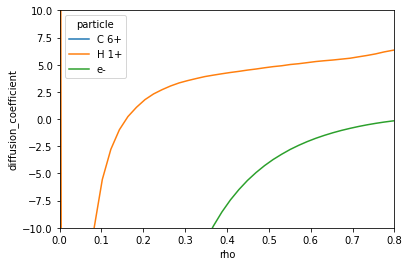

In [19]:
results.diffusion_coefficient.plot.line(x="rho")
plt.xlim(0, 0.8)
plt.ylim(-10, 10)

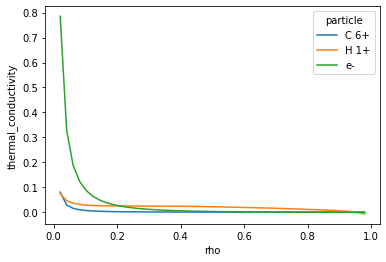

In [20]:
results.thermal_conductivity.plot.line(x="rho")

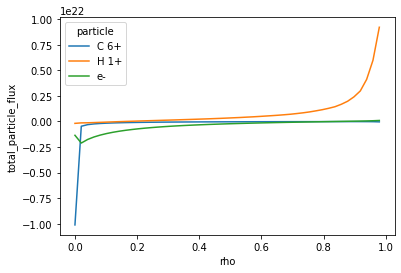

In [21]:
results.total_particle_flux.plot.line(x="rho")

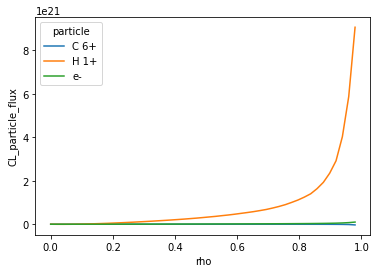

In [22]:
results.CL_particle_flux.plot.line(x="rho")

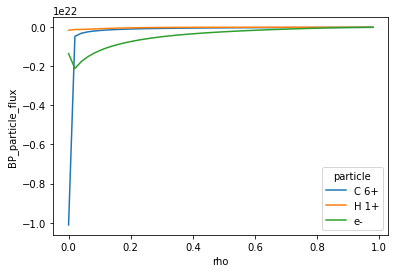

In [23]:
results.BP_particle_flux.plot.line(x="rho")

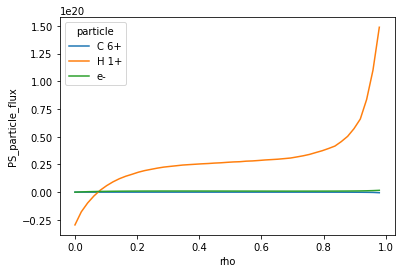

In [24]:
results.PS_particle_flux.plot.line(x="rho")

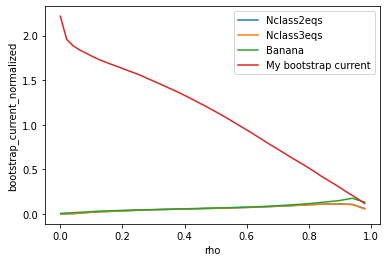

In [25]:
import pandas as pd

plt.figure()
df = pd.read_csv("/home/dominik/IFPILM/Magisterka/NSTXplot1.csv")
paper_results = xarray.Dataset.from_dataframe(df).swap_dims({"index": "x"}).drop("index").rename({"x": "rho"})

for values in paper_results:
    paper_results[values].plot.line(x="rho", label=values)
results.bootstrap_current_normalized.plot.line(x="rho", label="My bootstrap current")
plt.legend()
# plt.ylim(0, 0.2)

In [26]:
surfaces[0].F_m3

<Quantity [1.17430715e-06, 1.63649065e-04, 3.84660930e-06] 1 / m2>

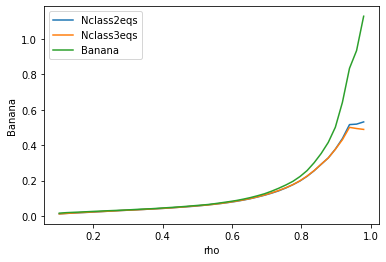

In [27]:
paper_results2 = paper_results.interp({"rho": results.rho})
diff = paper_results2 / results.bootstrap_current_normalized
diff = diff.where(diff.rho > 0.1)
for key in diff:
    diff[key].plot.line(x="rho", label=key)
plt.legend()

TypeError: 'FluxSurface' object is not subscriptable

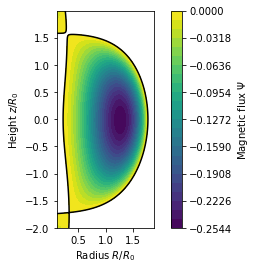

In [28]:
directions = ["poloidal", "toroidal", "parallel", "perpendicular"]
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    surfaces[5][1].plot(
        ax, quantity=fcs[-5].local_flow_velocities["H 1+"][index].value, legend=False
    )
    ax.set_title(label)

In [ ]:
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    for (psi, surface), fc in zip(surfaces, fcs):
        surface.plot(
            ax,
            quantity=fc.local_flow_velocities["H 1+"][index].value,
            legend=False,
            colorbar=False,
        )
    ax.set_title(label)